In [34]:
# Choose the directory for annotations
import json
import os

annotation_set = "describe-bird-attributes-night2"



In [35]:
# Create list of all birds and their individual annotations
# Structure: Nested dictionaries. key = Bird ID. Dictionary
# contains bird name and annotations
'''
{
    BirdID: {
        Bird Filename
        Labels []
    }
}
'''
annotations_dir = annotation_set + "/annotations/consolidated-annotation/consolidation-request/iteration-1/"

directory = os.fsencode(annotations_dir)
bird_annotations = {}

for file in os.listdir(directory):
    filename = annotations_dir + os.fsdecode(file)
    with open(filename, "r") as f:
        data = json.load(f)
    f.close()
    
    for bird in data:
        bird_annotations[bird["datasetObjectId"]] = {}

        curr_labels = {}
        #32 = where file name starts
        curr_labels["bird_filename"] = bird["dataObject"]["s3Uri"][32:] 
        curr_labels["labels"] = []

        for annotation in bird["annotations"]:
            # 36 = where label starts. -3 = cut off the last extra characters ("}})
            curr_labels["labels"].append(annotation["annotationData"]["content"][36:-3]) 

        bird_annotations[bird["datasetObjectId"]] = curr_labels


In [36]:
# Add confidence score and aggregate label
annotations_dir = annotation_set + "/annotations/consolidated-annotation/consolidation-response/iteration-1/"

directory = os.fsencode(annotations_dir)
for file in os.listdir(directory):
    filename = annotations_dir + os.fsdecode(file)
    with open(filename, "r") as f:
        data = json.load(f)
    f.close()
    
    for bird in data:
        bird_annotations[bird["datasetObjectId"]]["aggregated_label"] = bird["consolidatedAnnotation"]["content"][annotation_set + "-metadata"]["class-name"]
        bird_annotations[bird["datasetObjectId"]]["confidence"] = bird["consolidatedAnnotation"]["content"][annotation_set + "-metadata"]["confidence"]

In [37]:
# Add average time per annotation
annotations_dir = annotation_set + "/annotations/worker-response/iteration-1/"

time_spent = []
for bird_id in os.listdir(annotations_dir):
    bird_path = annotations_dir + bird_id + "/"
    for file in os.listdir(bird_path):       
        filename = bird_path + os.fsdecode(file)
        with open(filename, "r") as f:
            data = json.load(f)
        f.close()
        
        sum = 0
        count = 0
        for answer in data["answers"]:
            time_spent.append(answer["timeSpentInSeconds"])
            sum += answer["timeSpentInSeconds"]
            count += 1.0
        
        bird_annotations[bird_id]["avg_time"] = sum / count
print(time_spent)

[11.0, 6.0, 40.0, 42.0, 116.0, 32.0, 6.0, 48.0, 54.0, 45.0, 9.0, 39.0, 11.0, 42.0, 112.0, 22.0, 10.0, 34.0, 77.0, 99.0, 23.0, 21.0, 19.0, 60.0, 24.0, 8.0, 26.0, 81.0, 91.0, 15.0, 20.0, 62.0, 42.0, 37.0, 104.0, 32.0, 18.0, 96.0, 53.0, 102.0, 39.0, 9.0, 13.0, 13.0, 56.0, 25.0, 10.0, 45.0, 13.0, 67.0, 8.0, 10.0, 15.0, 45.0, 117.0, 40.0, 36.0, 8.0, 39.0, 45.0, 10.0, 20.0, 110.0, 70.0, 91.0, 11.0, 79.0, 47.0, 99.0, 51.0, 14.0, 27.0, 45.0, 87.0, 17.0, 40.0, 60.0, 47.0, 21.0, 29.0, 24.0, 11.0, 19.0, 23.0, 23.0, 6.0, 40.0, 76.0, 91.0, 68.0, 7.0, 11.0, 25.0, 71.0, 47.0, 9.0, 61.0, 34.0, 18.0, 105.0, 57.0, 25.0, 32.0, 23.0, 108.0, 35.0, 12.0, 22.0, 16.0, 57.0, 15.0, 9.0, 32.0, 28.0, 9.0, 24.0, 63.0, 25.0, 73.0, 117.0, 6.0, 7.0, 53.0, 100.0, 72.0, 25.0, 59.0, 108.0, 66.0, 113.0, 9.0, 20.0, 9.0, 22.0, 24.0, 55.0, 17.0, 36.0, 64.0, 75.0, 53.0, 64.0, 27.0, 101.0, 29.0, 42.0, 16.0, 58.0, 49.0, 115.0, 44.0, 68.0, 60.0, 74.0, 93.0, 35.0, 25.0, 99.0, 80.0, 23.0, 22.0, 99.0, 57.0, 22.0, 16.0, 21.0, 49.0,

In [38]:
# View the bird annotations in numerical order
from natsort import natsorted
dict(natsorted(bird_annotations.items()))

ModuleNotFoundError: No module named 'natsort'

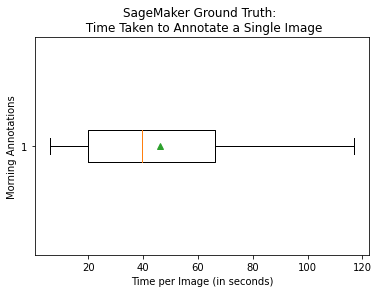

In [39]:
# Adding box and whisker plot for Sagemaker annotations
import matplotlib.pyplot as plt
plt.boxplot(time_spent, vert=False, showmeans=True,)
plt.title("SageMaker Ground Truth: \n Time Taken to Annotate a Single Image")
plt.xlabel("Time per Image (in seconds)")
plt.ylabel("Morning Annotations")

plt.show()

In [40]:
import statistics
statistics.mean(time_spent)

46.14

In [41]:
print(bird_annotations['0'])

{'bird_filename': 'American_Goldfinch_0022_32111.jpg', 'labels': ['Striped', 'Striped', 'Multi-Colored', 'Solid', 'Striped'], 'aggregated_label': 'Striped', 'confidence': 0.95, 'avg_time': 43.0}


In [42]:
import re
pattern = r'_\d+_\d+.jpg'
species_stats = {}
for bird in sorted(bird_annotations.items()):
    data = bird[1]
    species_name = re.sub(pattern, '', data['bird_filename'])
    #print(species_name)
    if species_name not in species_stats:
        species_stats[species_name] = {'Solid': 0, 'Striped': 0, 'Spotted': 0, 'Multi-Colored': 0}
    for label in data['labels']:
        species_stats[species_name][label] += 1
print(species_stats)


{'American_Goldfinch': {'Solid': 1, 'Striped': 4, 'Spotted': 3, 'Multi-Colored': 7}, 'Cardinal': {'Solid': 7, 'Striped': 2, 'Spotted': 3, 'Multi-Colored': 3}, 'Cerulean_Warbler': {'Solid': 1, 'Striped': 9, 'Spotted': 3, 'Multi-Colored': 2}, 'Chuck_Will_Widow': {'Solid': 0, 'Striped': 2, 'Spotted': 10, 'Multi-Colored': 3}, 'Clay_Colored_Sparrow': {'Solid': 1, 'Striped': 6, 'Spotted': 8, 'Multi-Colored': 0}, 'Green_Kingfisher': {'Solid': 2, 'Striped': 3, 'Spotted': 8, 'Multi-Colored': 2}, 'Hooded_Oriole': {'Solid': 2, 'Striped': 5, 'Spotted': 0, 'Multi-Colored': 8}, 'Least_Auklet': {'Solid': 1, 'Striped': 1, 'Spotted': 11, 'Multi-Colored': 2}, 'Blue_Grosbeak': {'Solid': 0, 'Striped': 6, 'Spotted': 3, 'Multi-Colored': 6}, 'Northern_Waterthrush': {'Solid': 4, 'Striped': 6, 'Spotted': 5, 'Multi-Colored': 0}, 'Palm_Warbler': {'Solid': 3, 'Striped': 4, 'Spotted': 6, 'Multi-Colored': 2}, 'Pileated_Woodpecker': {'Solid': 4, 'Striped': 1, 'Spotted': 8, 'Multi-Colored': 2}, 'Purple_Finch': {'Soli

In [43]:
total = 15 # num images per species
for bird in species_stats.items():
    #print(bird[1])
    print('{}: Solid {}% | Spotted {}% | Striped {}% | Multi {}% \n'.format(
        bird[0],
        round(bird[1]['Solid'] / total * 100, 2),
        round(bird[1]['Spotted'] / total * 100,2),
        round(bird[1]['Striped'] / total * 100, 2),
        round(bird[1]['Multi-Colored'] / total * 100, 2)))

American_Goldfinch: Solid 6.67% | Spotted 20.0% | Striped 26.67% | Multi 46.67% 

Cardinal: Solid 46.67% | Spotted 20.0% | Striped 13.33% | Multi 20.0% 

Cerulean_Warbler: Solid 6.67% | Spotted 20.0% | Striped 60.0% | Multi 13.33% 

Chuck_Will_Widow: Solid 0.0% | Spotted 66.67% | Striped 13.33% | Multi 20.0% 

Clay_Colored_Sparrow: Solid 6.67% | Spotted 53.33% | Striped 40.0% | Multi 0.0% 

Green_Kingfisher: Solid 13.33% | Spotted 53.33% | Striped 20.0% | Multi 13.33% 

Hooded_Oriole: Solid 13.33% | Spotted 0.0% | Striped 33.33% | Multi 53.33% 

Least_Auklet: Solid 6.67% | Spotted 73.33% | Striped 6.67% | Multi 13.33% 

Blue_Grosbeak: Solid 0.0% | Spotted 20.0% | Striped 40.0% | Multi 40.0% 

Northern_Waterthrush: Solid 26.67% | Spotted 33.33% | Striped 40.0% | Multi 0.0% 

Palm_Warbler: Solid 20.0% | Spotted 40.0% | Striped 26.67% | Multi 13.33% 

Pileated_Woodpecker: Solid 26.67% | Spotted 53.33% | Striped 6.67% | Multi 13.33% 

Purple_Finch: Solid 20.0% | Spotted 13.33% | Striped 40